In [3]:
import pandas as pd

# Load the uploaded Walmart Sales dataset
file_path = "Walmart_Sales.csv"
df = pd.read_csv(file_path)

# Show the first few rows
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv("Walmart_Sales.csv")

# Filter only Store 1 for simplicity
df_store1 = df[df['Store'] == 1].sort_values('Date')

# Select features and target
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
target = 'Weekly_Sales'

# Normalize
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(df_store1[features])
y_scaled = scaler_y.fit_transform(df_store1[[target]])

# Create sequences
sequence_length = 4
X_seq, y_seq = [], []
for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# PyTorch Dataset
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SalesDataset(X_seq, y_seq)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# RNN Model
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNRegressor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Use last time step
        return self.fc(out)

# Model setup
model = RNNRegressor(input_size=len(features), hidden_size=32, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/50], Loss: {total_loss:.4f}")


Epoch [1/50], Loss: 0.6199
Epoch [10/50], Loss: 0.1849
Epoch [20/50], Loss: 0.1811
Epoch [30/50], Loss: 0.1813
Epoch [40/50], Loss: 0.1882
Epoch [50/50], Loss: 0.1900


Epoch [1/50], Loss: 0.2448
Epoch [10/50], Loss: 0.1948
Epoch [20/50], Loss: 0.1893
Epoch [30/50], Loss: 0.1952
Epoch [40/50], Loss: 0.1852
Epoch [50/50], Loss: 0.1863


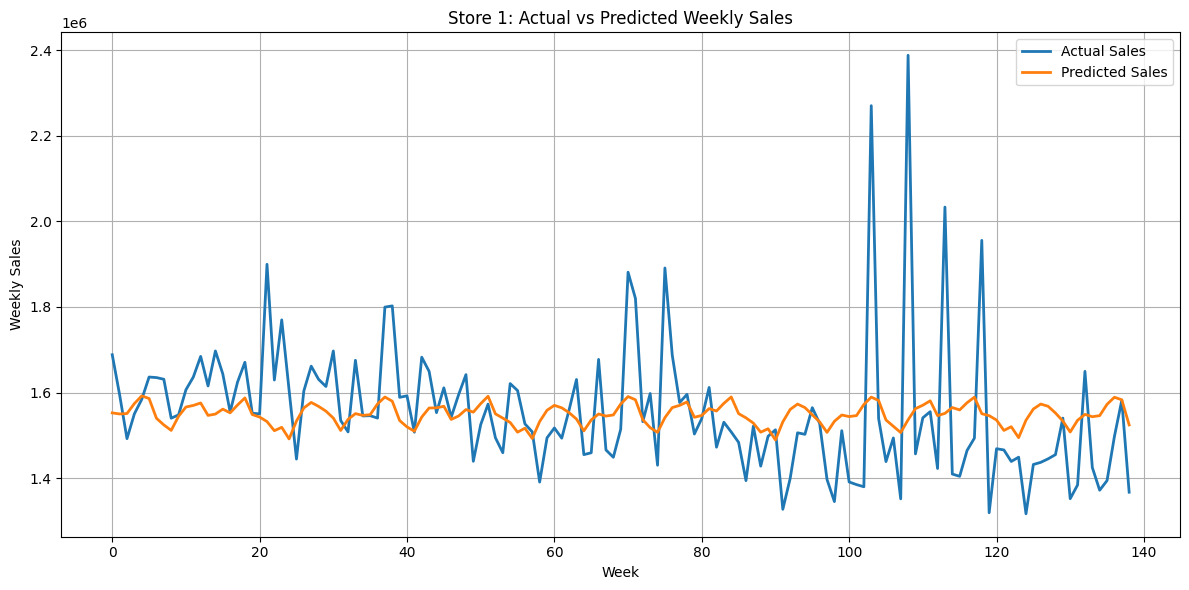

Predicted sales for next 10 weeks (Store 1):
[1529194.76579409 1527030.76268751 1533551.13275303 1546815.71050905
 1545532.59823118 1545286.40078356 1544934.45302557 1544715.27569197
 1544740.22101873 1544753.91461461]


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import os

# PARAMETERS
STORE_ID = 1
SEQUENCE_LENGTH = 4
EPOCHS = 30
FUTURE_WEEKS = 10
BATCH_SIZE = 32

# Load data
df = pd.read_csv("Walmart_Sales.csv")
df = df.sort_values(['Store', 'Date'])
df_store = df[df['Store'] == STORE_ID]

# Features and target
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
target = 'Weekly_Sales'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(df_store[features])
y_scaled = scaler_y.fit_transform(df_store[[target]])

# Save scalers
joblib.dump(scaler_x, "scaler_x.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# Sequence generation
X_seq, y_seq = [], []
for i in range(len(X_scaled) - SEQUENCE_LENGTH):
    X_seq.append(X_scaled[i:i+SEQUENCE_LENGTH])
    y_seq.append(y_scaled[i+SEQUENCE_LENGTH])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Dataset
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SalesDataset(X_seq, y_seq)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = LSTMRegressor(input_size=len(features), hidden_size=32, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}")

# Save model
torch.save(model.state_dict(), "lstm_sales_model.pth")

# Evaluation and Plot
model.eval()
with torch.no_grad():
    all_preds = model(torch.tensor(X_seq, dtype=torch.float32)).squeeze().numpy()

y_true = scaler_y.inverse_transform(y_seq)
y_pred = scaler_y.inverse_transform(all_preds.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_true, label="Actual Sales", linewidth=2)
plt.plot(y_pred, label="Predicted Sales", linewidth=2)
plt.title(f"Store {STORE_ID}: Actual vs Predicted Weekly Sales")
plt.xlabel("Week")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sales_prediction_plot.png")
plt.show()

# Future Prediction
last_seq = X_scaled[-SEQUENCE_LENGTH:]
future_preds = []
model.eval()
with torch.no_grad():
    for _ in range(FUTURE_WEEKS):
        input_seq = torch.tensor(last_seq[np.newaxis, :, :], dtype=torch.float32)
        next_pred = model(input_seq).item()
        future_preds.append(next_pred)

        # Append prediction and shift window
        next_input = np.append(last_seq[1:], [[next_pred] * len(features)], axis=0)
        last_seq = next_input

# Inverse scale future predictions
future_sales = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))

print(f"Predicted sales for next {FUTURE_WEEKS} weeks (Store {STORE_ID}):")
print(future_sales.flatten())

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import os

# PARAMETERS
SEQUENCE_LENGTH = 4
EPOCHS = 50
FUTURE_WEEKS = 10
BATCH_SIZE = 16

# Load data
df = pd.read_csv("Walmart_Sales.csv")
df = df.sort_values(['Store', 'Date'])

features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
target = 'Weekly_Sales'

# Dataset class and model class remain unchanged:
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# Dictionary to store future predictions for all stores
all_stores_future_preds = {}

store_ids = df['Store'].unique()

for store_id in store_ids:
    print(f"\nProcessing Store {store_id}")

    df_store = df[df['Store'] == store_id]

    # Scale features and target
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_x.fit_transform(df_store[features])
    y_scaled = scaler_y.fit_transform(df_store[[target]])

    # Generate sequences
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - SEQUENCE_LENGTH):
        X_seq.append(X_scaled[i:i+SEQUENCE_LENGTH])
        y_seq.append(y_scaled[i+SEQUENCE_LENGTH])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Dataset and DataLoader
    dataset = SalesDataset(X_seq, y_seq)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Model, criterion, optimizer
    model = LSTMRegressor(input_size=len(features), hidden_size=32, num_layers=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}")

    # Future Prediction
    last_seq = X_scaled[-SEQUENCE_LENGTH:]
    future_preds = []
    model.eval()
    with torch.no_grad():
        for _ in range(FUTURE_WEEKS):
            input_seq = torch.tensor(last_seq[np.newaxis, :, :], dtype=torch.float32)
            next_pred = model(input_seq).item()
            future_preds.append(next_pred)

            # For future features, keep last known feature values (you can improve this)
            next_features = last_seq[-1, :]  # keep last feature vector as is
            # Replace sales feature in your features vector? Your model input is only features, so no sales inside features
            # But your model predicts sales from features, so no need to append predicted sales to features here
            last_seq = np.vstack((last_seq[1:], next_features))

    # Inverse scale future sales
    future_sales = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))

    all_stores_future_preds[store_id] = future_sales.flatten()

    print(f"Predicted sales for next {FUTURE_WEEKS} weeks (Store {store_id}):")
    print(future_sales.flatten())

# Now you have predictions for all stores
# Optionally, save or plot per store



Processing Store 1
Epoch [1/50], Loss: 0.2204
Epoch [10/50], Loss: 0.1885
Epoch [20/50], Loss: 0.1867
Epoch [30/50], Loss: 0.1843
Epoch [40/50], Loss: 0.1814
Epoch [50/50], Loss: 0.1813
Predicted sales for next 10 weeks (Store 1):
[1523313.98879957 1544175.55968743 1569406.47293454 1594055.87119387
 1594055.87119387 1594055.87119387 1594055.87119387 1594055.87119387
 1594055.87119387 1594055.87119387]

Processing Store 2
Epoch [1/50], Loss: 0.1627
Epoch [10/50], Loss: 0.1639
Epoch [20/50], Loss: 0.1522
Epoch [30/50], Loss: 0.1509
Epoch [40/50], Loss: 0.1418
Epoch [50/50], Loss: 0.1466
Predicted sales for next 10 weeks (Store 2):
[1854406.46768697 1905075.81059033 1888357.99969154 1977145.10994387
 1977145.10994387 1977145.10994387 1977145.10994387 1977145.10994387
 1977145.10994387 1977145.10994387]

Processing Store 3
Epoch [1/50], Loss: 0.7935
Epoch [10/50], Loss: 0.2703
Epoch [20/50], Loss: 0.2632
Epoch [30/50], Loss: 0.2554
Epoch [40/50], Loss: 0.2588
Epoch [50/50], Loss: 0.2656
P

KeyboardInterrupt: 